<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/chembert/chemberta_ADMET_old_vocab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [2]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet


# specific for chemberta
!pip uninstall transformers -y
!pip install transformers==4.30.2 --quiet

  Preparing metadata (setup.py) ... done


In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [2]:
from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *
from scripts.TRAIN import *
from scripts.MUE import *
print('VOCAB TYPE:', VOCAB_TYPE)

VOCAB TYPE: smiles


In [3]:
import torch
import torch.nn as nn
from transformers import AutoModelWithLMHead, AutoTokenizer

import torch
adj_max=80
fps_len=167
max_len=120

vocabulary = {'C': 1, 'c': 2, '1': 3, '(': 4, '-': 5, '2': 6, 's': 7, 'N': 8,
              '=': 9, ')': 10, 'n': 11, '[': 12, '@': 13,
                  'H': 14, ']': 15, 'O': 16, 'S': 17, '3': 18, 'l': 19, 'B': 20, 'r': 21, '/': 22, '\\': 23, 'o': 24,
                  '4': 25,
                  '5': 26, '6': 27, '7': 28, '+': 29, '.': 30, 'I': 31, 'F': 32, '8': 33, '#': 34, 'P': 35, '9': 36,
                  'a': 37,
                  '%': 38, '0': 39, 'i': 40, 'e': 41, 'L': 42, 'K': 43, 't': 44, 'T': 45, 'A': 46, 'g': 47, 'Z': 48,
                  'M': 49,
                  'R': 50, 'p': 51, 'b': 52, 'X': 53}

cuda_available = True

class chembert_encoder(nn.Module):
    def __init__(self, output_dim=fps_len,dropout=0.5):
        super(chembert_encoder, self).__init__()
        pretrained_path = "seyonec/ChemBERTa-zinc-base-v1"
        self.bert = AutoModelWithLMHead.from_pretrained(pretrained_path)
        self.tokenizer =  AutoTokenizer.from_pretrained(pretrained_path)
        self.dropout=nn.Dropout(dropout)
        self.w=nn.Linear(767,output_dim)

    def forward(self, x):
        input_feat = self.tokenizer.batch_encode_plus(x, max_length=512,
                                                 padding='longest',  # implements dynamic padding
                                                 truncation=True,
                                                 return_tensors='pt',
                                                 return_attention_mask=True,
                                                 return_token_type_ids=True
                                                 )

        if cuda_available:
            input_feat['attention_mask'] = input_feat['attention_mask'].cuda()
            input_feat['input_ids'] = input_feat['input_ids'].cuda()


        outputs = self.bert(input_feat['input_ids'],
                            attention_mask=input_feat['attention_mask'],
                            output_hidden_states=None).logits[:,0,:]

        return self.w(self.dropout(outputs))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from encoder import encoder


if torch.cuda.is_available(): device='cuda'
else: device='cpu'

class chembertforclassification(nn.Module):
    def __init__(self, output_size=2,
                 load_path='/content/drive/MyDrive/chemberta/checkpoints/chem_bert_encoder_pretrain_9.pt',
                 last_layer_size=fps_len, dropout=0.5):
        super(chembertforclassification, self).__init__()

        self.last_layer_size = last_layer_size
        self.output_size = output_size
        self.pretrained = chembert_encoder()
        self.pretrained.load_state_dict(
            torch.load(load_path, map_location=device))

        self.w = nn.Linear(self.last_layer_size, self.output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        return self.w(self.dropout(self.pretrained(x)))


from torch.utils.data import DataLoader, Dataset
class chemberta_dataset(Dataset):
    def __init__(self, df, prop_names, vocab=vocabulary, vocab_type='smiles',
                 device='cpu', mask=MASK):
        super(chemberta_dataset, self).__init__()
        self.df = df.fillna(mask)
        self.device = device
        self.len = len(df)

        for col_smi in ['smiles', 'Drug', 'SMILES', 'Smiles', 'smile']:
            if col_smi in self.df.columns:
                self.smi = self.df[col_smi]; break
        self.props = self.df[prop_names]
        self.vocab_type = vocab_type

    def __getitem__(self, idx):
        lab = torch.tensor(self.props.iloc[idx],
                           dtype=torch.float32).to(self.device)
        smi = self.smi[idx]

        return [smi, lab]

    def __len__(self): return self.len

In [10]:
name = names_cls[0]
trn, val, tst = collect_data(name)
if isinstance(name, str): name = [name]
is_r = [names_dict[n] for n in name]
print(is_r)

Found local copy...
Loading...
Done!


collect data for:  ['CYP2C19_Veith']
[False]


In [11]:
params = {'batch_size':16, 'shuffle': True, 'drop_last':False, 'num_workers':0}
trn_l = DataLoader(chemberta_dataset(trn, name), **params)
val_l = DataLoader(chemberta_dataset(val, name), **params)
tst_l = DataLoader(chemberta_dataset(tst, name), **params)
for idx, (x, y_true) in enumerate(trn_l):
    y_true = y_true.reshape(len(y_true), 1)
    print(y_true.shape)
    break

torch.Size([16, 1])


In [12]:
model = chembertforclassification(output_size=len(name)).cuda()
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5, weight_decay=1e-2)
loss_function = nn.CrossEntropyLoss().cuda()

In [ ]:
for epoch in range(20):
    train_epoch_MLP(model, trn_l, is_r, name, device='cuda',
                epoch=epoch, optimizer=optimizer, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=True)

    train_epoch_MLP(model, val_l, is_r, name, device='cuda',
                epoch=epoch, optimizer=None, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=True)

_ = train_epoch_MLP(model, tst_l, is_r, name, device='cuda',
                epoch=None, optimizer=None, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=True)

Epoch:0, [Train] Loss: 0.569
Epoch:0, [Valid] Loss: 0.472
Epoch:1, [Train] Loss: 0.453
Epoch:1, [Valid] Loss: 0.435
Epoch:2, [Train] Loss: 0.410
Epoch:2, [Valid] Loss: 0.421
Epoch:3, [Train] Loss: 0.378
Epoch:3, [Valid] Loss: 0.417
Epoch:4, [Train] Loss: 0.353
Epoch:4, [Valid] Loss: 0.416


In [11]:
from IPython.display import Code

[Test] Loss: 0.264
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2     pcc     spearman
&0.403  &0.265  &0.515  &0.582  &0.769  &0.696


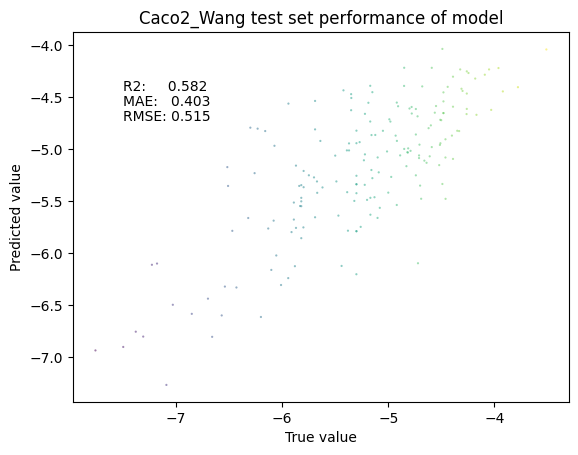

In [ ]:
Code('scripts/train.py')

In [ ]:
def train_epoch_MLP_v1(model, loader, IS_R, names, device,
                    epoch=None, optimizer=None, MASK=-100,
                    scale_dict=None, weight_loss=None,
                    model_type='model', ver=False):
    """
    param weight_loss: list, the weight of loss for different tasks
    """

    if optimizer==None: # no optimizer, either validation or test
        model.eval()    # model evaluation for either valid or test
        if epoch != None: train_type='Valid' # if epoch is inputted, its valid
        else: train_type = 'Test' # if no epoch information, its test
    else: model.train(); train_type='Train' # if optimizer inputted, its train
    print(names)
    if isinstance(names, str): names = [names]
    if isinstance(IS_R, list): IS_R_list = IS_R
    else: IS_R_list = [IS_R] * len(names)
    if weight_loss == None: weight_loss = [1.0/len(names)]*len(names)

    total_loss, losses_list, y_probs, y_label = 0, [], {}, {}
    for idx, batch_data in enumerate(loader):
        """
        len(batch_data) could determine which algorithm
        len(batch_data) == 2: MLP, GIN, RNN, ENSEMBLE, chemberta
        len(batch_data) == 4: AttentiveFP
        """
        if len(batch_data) == 2:  # MLP or GIN or RNN

            fp, labels = batch_data
            labels = labels.to(device)
            try: fp = fp.to(device) # MLP, GIN, RNN
            except:
                fp = list(fp)   # actually SMILES, convert tuple to list
                labels = labels.reshape(len(fp), len(names))

            mask = labels == MASK
            pred = model(fp)
            assert labels.shape == pred.shape
            # print(labels.shape, pred.shape, mask.shape)

        elif len(batch_data) == 4: # attentiveFP
            smiles, bg, labels, masks = batch_data
            bg,labels,masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            pred = model(bg, n_feats, e_feats)
            mask = masks < 1

        batch_loss_list = []
        for j, (name, IS_R, w) in enumerate(zip(names, IS_R_list, weight_loss)):
            loss_func = get_loss_fn(IS_R)
            # print(pred[:, j].shape)
            probs = pred[:, j][~mask[:, j]]
            label = labels[:, j][~mask[:, j]]

            len_here = label.shape[0] # num of data with labels
            loss_here = loss_func(probs, label)
            if len_here != 0:
                loss_here /= len_here
                batch_loss_list.append(loss_here.item())
            else:       batch_loss_list.append(float(0))

            if j == 0: loss  = loss_here * w
            else:      loss += loss_here * w

            if IS_R == False: probs = F.sigmoid(probs)
            if train_type != 'Train': # valid or test, output probs and labels
                                      # if train, no process prob to save time
                probs = probs.cpu().detach().numpy().tolist()
                label = label.cpu().detach().numpy().tolist()
                if scale_dict != None:
                    if name in scale_dict.keys():
                        min_here = scale_dict[name][0]
                        max_here = scale_dict[name][1]
                        del_here = max_here - min_here
                        label = [l * del_here + min_here for l in label]
                        probs = [p * del_here + min_here for p in probs]

                if idx == 0: y_probs[name], y_label[name] = probs, label
                else:     y_probs[name] += probs; y_label[name] += label

        if len(losses_list) == 0:               losses_list = batch_loss_list
        else: losses_list = [i+j for i, j in zip(losses_list, batch_loss_list)]

        total_loss += loss.item()

        if optimizer != None:
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    total_loss /= len(loader) # no need /loader.dataset since has / len_here

    if epoch != None: # train or valid
        if ver: print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')

    elif epoch == None: # test
        print(f'[{train_type}] Loss: {total_loss:.3f}')
        performance = eval_dict(y_probs, y_label, names, IS_R_list,
                                model_type=model_type, draw_fig=True)
        performance['loss'] = float(total_loss)

    IS_R = IS_R_list
    if   train_type == 'Train': return total_loss, losses_list, IS_R # train
    elif train_type == 'Valid': return total_loss,  y_probs, y_label # valid
    else:                       return performance, y_probs, y_label # test

for epoch in range(20):
    train_epoch_MLP(model, trn_l, is_r, name, device='cuda',
                epoch=epoch, optimizer=optimizer, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=True)

    train_epoch_MLP(model, val_l, is_r, name, device='cuda',
                epoch=epoch, optimizer=None, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=True)

    train_epoch_MLP(model, tst_l, is_r, name, device='cuda',
                epoch=None, optimizer=None, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=True)

In [ ]:
model.train()
total_loss = 0
temp_path = 'ckpt.pt'
for epoch in range(20):
    for idx, (x, y_true) in enumerate(trn_l):
        optimizer.zero_grad()

        output = model(list(x))
        print(output)
        break
#         loss = loss_function(output, y_true.cuda())
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
# torch.save(model.state_dict(), temp_path)

In [49]:
output.shape

torch.Size([16, 1])

In [9]:
config_MLP = get_config('MLP', name)
trn_l_M, val_l_M, tst_l_M, v = get_multi_loader(trn, val, tst, config_MLP)
models = PRED(**config_MLP)
model_MLP = models.model

optimizer_MLP = optim.AdamW(params=model_MLP.parameters(), lr=1e-5, weight_decay=1e-2)



---> loader for ['CYP2C19_Veith']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  32385


In [ ]:
train_epoch_MLP(model_MLP, trn_l_M, names_dict[name], name, device='cuda',
                epoch=1, optimizer=optimizer_MLP, MASK=-100,
                scale_dict=None, weight_loss=None,
                model_type='model', ver=False)

In [58]:
model_MLP

Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=167, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (final): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)